# **Table of Contents**
- [Assignment Task](#assignment-task)
- [Load Dataset](#load-dataset)
- [Data Processing](#data-processing)
- [Model Training and Evaluation - Logistic Regression](#model-training-and-evaluation---logistic-regression)
- [Model Training and Evaluation - Support Vector Machine](#model-training-and-evaluation---support-vector-machine)
- [Model Training and Evaluation - DistilBERT](#model-training-and-evaluation---distilbert)


#Assignment Task




Your task is to classify a set of text data you find online (i.e. Kaggle, Hugging face etc.). Please indicate the source of your data during the presentation (in slides) and quote the source, including the link/s, in your Google Colab as well.


1.
This project should involve preprocessing of the raw  data, including tokenization, stop word removal, stemming/lemmatization, and feature extraction. These preprocessing steps will help in converting the unstructured text into a structured numerical format that can be processed by machine learning algorithms. And, of course, you will have to convert the text to appropriate word representation.


2.
The performance of the model will be evaluated using various metrics such as accuracy, precision, recall, and F1 score.


3.
You may also choose to use the appropriate Hugging Face transformers model to do classification if you like.


# Load Dataset

- Load Dataset from Hugging Face: https://huggingface.co/datasets/stanfordnlp/imdb and combine raw data into a single dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

target_folder = '/content/drive/MyDrive/SPNLP/FINAL/'

Mounted at /content/drive


In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd

In [ ]:
# Load and export IMDB dataset
dataset = load_dataset("stanfordnlp/imdb")

# Save train, test, and combined datasets
train_file = f"{target_folder}/imdb_train.csv"
test_file = f"{target_folder}/imdb_test.csv"
combined_file = f"{target_folder}/imdb_combined.csv"

dataset["train"].to_csv(train_file)
dataset["test"].to_csv(test_file)

pd.concat([
    pd.read_csv(train_file),
    pd.read_csv(test_file)
], ignore_index=True).to_csv(combined_file, index=False)

print(f"Train: {train_file}\nTest: {test_file}\nCombined: {combined_file}")

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Train: /content/drive/MyDrive/SPNLP/FINAL//imdb_train.csv
Test: /content/drive/MyDrive/SPNLP/FINAL//imdb_test.csv
Combined: /content/drive/MyDrive/SPNLP/FINAL//imdb_combined.csv


In [ ]:
# Load the dataset from the CSV file
dataset = pd.read_csv(combined_file)

# Data Processing

- Check for null values

In [ ]:
null_counts = dataset.isnull().sum()
print(null_counts)

text     0
label    0
dtype: int64


There are no null values for dataset.

- Drop Duplicate Reviews

In [ ]:
# Drop duplicate reviews based on the 'text' column
dataset = dataset.drop_duplicates(subset='text', keep='first')

# Verify the number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(dataset)}")

# Save the cleaned dataset to a new file
cleaned_file_path = f"{target_folder}/cleaned_combined.csv"
dataset.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_file_path}")

Number of rows after removing duplicates: 49582
Cleaned dataset saved to: /content/drive/MyDrive/SPNLP/FINAL//cleaned_combined.csv


 - Split dataset into train (80%) and test (20%)

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Load raw dataset
raw_data = pd.read_csv(f"{target_folder}/cleaned_combined.csv")

# Split the dataset into features (X) and labels (y)
X = raw_data["text"]
y = raw_data["label"]

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the sizes of the splits
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Save the splits to CSV files
train_data = pd.DataFrame({"text": X_train, "label": y_train})
test_data = pd.DataFrame({"text": X_test, "label": y_test})

train_data.to_csv(f"{target_folder}train_raw_data.csv", index=False)
test_data.to_csv(f"{target_folder}test_raw_data.csv", index=False)
print("Training and testing datasets saved.")

Number of training samples: 39665
Number of testing samples: 9917
Training and testing datasets saved.


**Preprocessing Pipeline for Traditional Models**


1. Remove hyperlinks
2. Remove HTML Tags
3. Expand Contractions
4. Convert Emoticons to Text
5. Remove Non-ASCII Characters
6. Convert to Lowercase

In [ ]:
!pip install contractions
!pip install -U emot
import pandas as pd
import re
import contractions
import emot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Initialize the emot library object
emot_obj = emot.core.emot()

# Preprocessing functions
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove hyperlinks
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = contractions.fix(text)  # Expand contractions
    emoticons_dict = emot_obj.emoticons(text)
    if emoticons_dict['flag']:
        for i, value in enumerate(emoticons_dict['value']):
            text = re.sub(re.escape(value), f" {emoticons_dict['mean'][i]} ", text)
    text = "".join(char for char in text if ord(char) < 128).strip()  # Remove non-ASCII characters
    text = text.lower()  # Convert to lowercase
    return text


In [ ]:
# File paths
train_file_path = f"{target_folder}/train_raw_data.csv"
test_file_path = f"{target_folder}/test_raw_data.csv"
train_save_path = f"{target_folder}/train_preprocessed.csv"
test_save_path = f"{target_folder}/test_preprocessed.csv"

In [ ]:
# Define a function to preprocess and save a dataset
def preprocess_and_save(file_path, save_path):
    # Load dataset
    dataset = pd.read_csv(file_path)

    # Apply preprocessing pipeline
    dataset['text'] = dataset['text'].apply(preprocess_text)  # Ensure 'text' is the correct column name

    # Save the preprocessed dataset
    dataset.to_csv(save_path, index=False)
    print(f"Preprocessing complete. Saved to: {save_path}")

In [ ]:
# Preprocess and save train and test datasets
preprocess_and_save(train_file_path, train_save_path)
preprocess_and_save(test_file_path, test_save_path)

Preprocessing complete. Saved to: /content/drive/MyDrive/SPNLP/FINAL//train_preprocessed.csv
Preprocessing complete. Saved to: /content/drive/MyDrive/SPNLP/FINAL//test_preprocessed.csv


In [ ]:
# Load train and test datasets
train_data = pd.read_csv(f"{target_folder}/train_preprocessed.csv")
test_data = pd.read_csv(f"{target_folder}/test_preprocessed.csv")

# Print the number of rows
print(f"Number of rows in train dataset: {len(train_data)}")
print(f"Number of rows in test dataset: {len(test_data)}")


Number of rows in train dataset: 39665
Number of rows in test dataset: 9917


- Lemmatization using spacy. Pipeline includes tokenization, POS tagging, and lemmatization.

In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

In [ ]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Lemmatization function using pipe() for batch processing
def lemmatize_texts(texts):
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=64, disable=["parser", "ner"]), desc="Lemmatizing"):
        lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))
    return lemmatized_texts

In [ ]:
# Function to lemmatize and save a dataset
def lemmatize_and_save(input_file, output_file):
    # Load the dataset
    dataset = pd.read_csv(input_file)

    # Apply lemmatization
    dataset['text'] = lemmatize_texts(dataset['text'])

    # Save the lemmatized dataset
    dataset.to_csv(output_file, index=False)
    print(f"Lemmatized dataset saved to: {output_file}")

In [ ]:
# File paths
train_preprocessed_path = f"{target_folder}/train_preprocessed.csv"
test_preprocessed_path = f"{target_folder}/test_preprocessed.csv"
train_lemmatized_path = f"{target_folder}/train_lemmatized.csv"
test_lemmatized_path = f"{target_folder}/test_lemmatized.csv"

In [ ]:
# Lemmatize and save train and test datasets
lemmatize_and_save(train_preprocessed_path, train_lemmatized_path)
lemmatize_and_save(test_preprocessed_path, test_lemmatized_path)

Lemmatizing: 39665it [13:42, 48.24it/s]


Lemmatized dataset saved to: /content/drive/MyDrive/SPNLP/FINAL//train_lemmatized.csv


Lemmatizing: 9917it [04:31, 36.48it/s]


Lemmatized dataset saved to: /content/drive/MyDrive/SPNLP/FINAL//test_lemmatized.csv


In [ ]:
# Load train and test datasets
train_data = pd.read_csv(f"{target_folder}/train_lemmatized.csv")
test_data = pd.read_csv(f"{target_folder}/test_lemmatized.csv")

# Print the number of rows
print(f"Number of rows in train dataset: {len(train_data)}")
print(f"Number of rows in test dataset: {len(test_data)}")

Number of rows in train dataset: 39665
Number of rows in test dataset: 9917


- Stopword removal

In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

In [ ]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Function for stopword removal using pipe() for batch processing
def remove_stopwords(texts):
    filtered_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=64, disable=["parser", "ner", "lemmatizer"]), desc="Removing stopwords"):
        filtered_texts.append(" ".join([token.text for token in doc if not token.is_stop]))
    return filtered_texts

In [ ]:
# Function for stopword removal and save a dataset
def stopword_and_save(input_file, output_file):
    # Load the dataset
    dataset = pd.read_csv(input_file)

    # Apply stopword removal
    dataset['text'] = remove_stopwords(dataset['text'])

    # Save the clean dataset
    dataset.to_csv(output_file, index=False)
    print(f"Stopword removed dataset saved to: {output_file}")

In [ ]:
# File paths
train_lemmatized_path = f"{target_folder}/train_lemmatized.csv"
test_lemmatized_path = f"{target_folder}/test_lemmatized.csv"
train_stopword_path = f"{target_folder}/train_stopword.csv"
test_stopword_path = f"{target_folder}/test_stopword.csv"

In [ ]:
# Stopword removed and save train and test datasets
stopword_and_save(train_lemmatized_path, train_stopword_path)
stopword_and_save(test_lemmatized_path, test_stopword_path)

Removing stopwords: 39665it [13:11, 50.10it/s]


Stopword removed dataset saved to: /content/drive/MyDrive/SPNLP/FINAL//train_stopword.csv


Removing stopwords: 9917it [02:57, 55.73it/s]


Stopword removed dataset saved to: /content/drive/MyDrive/SPNLP/FINAL//test_stopword.csv


In [ ]:
# Load train and test datasets
train_data = pd.read_csv(f"{target_folder}/train_stopword.csv")
test_data = pd.read_csv(f"{target_folder}/test_stopword.csv")

# Print the number of rows
print(f"Number of rows in train dataset: {len(train_data)}")
print(f"Number of rows in test dataset: {len(test_data)}")

Number of rows in train dataset: 39665
Number of rows in test dataset: 9917


- Feature extraction using Tf-idf

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [ ]:
# Load training and testing datasets
train_data = pd.read_csv(f"{target_folder}/train_stopword.csv")
test_data = pd.read_csv(f"{target_folder}/test_stopword.csv")

# Extract the text and labels
X_train = train_data["text"]
y_train = train_data["label"]

X_test = test_data["text"]
y_test = test_data["label"]

# Step 1: Fit TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Step 2: Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Save the transformed datasets
joblib.dump(X_train_tfidf, '/content/drive/MyDrive/SPNLP/FINAL/X_train_tfidf.pkl')
joblib.dump(X_test_tfidf, '/content/drive/MyDrive/SPNLP/FINAL/X_test_tfidf.pkl')

print("TF-IDF transformed data saved.")

TF-IDF transformed data saved.


In [ ]:
# Calculate and print the number of rows in the training dataset
train_rows = X_train_tfidf.shape[0]
print(f"Number of rows in the training dataset: {train_rows}")

# Calculate and print the number of rows in the testing dataset
test_rows = X_test_tfidf.shape[0]
print(f"Number of rows in the testing dataset: {test_rows}")

Number of rows in the training dataset: 39665
Number of rows in the testing dataset: 9917


#Model Training and Evaluation - Logistic Regression

- Train model using Logistic Regression

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import json


In [ ]:
# Load tfidf train and test dataset
X_train_tfidf = joblib.load(f"{target_folder}/X_train_tfidf.pkl")
X_test_tfidf = joblib.load (f"{target_folder}/X_test_tfidf.pkl")

# Load the labels
train_data = pd.read_csv(f"{target_folder}/train_stopword.csv")
test_data = pd.read_csv(f"{target_folder}/test_stopword.csv")
y_train = train_data["label"]
y_test = test_data["label"]


In [ ]:
# Train logistic regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Save the trained Logistic Regression model
joblib.dump(lr_model, f"{target_folder}/logistic_regression_model.pkl")
print("Logistic Regression model saved.")

Logistic Regression model saved.


- Test data on Logistic Regression model

In [ ]:
# Load the Trained LR Model
lr_model = joblib.load(f"{target_folder}/logistic_regression_model.pkl")

# Evaluate the model on the test data
y_test_pred = lr_model.predict(X_test_tfidf)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4980
           1       0.88      0.91      0.89      4937

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Logistic Regression Test Report saved to: /content/drive/MyDrive/SPNLP/FINAL//logistic_regression_test_report.json


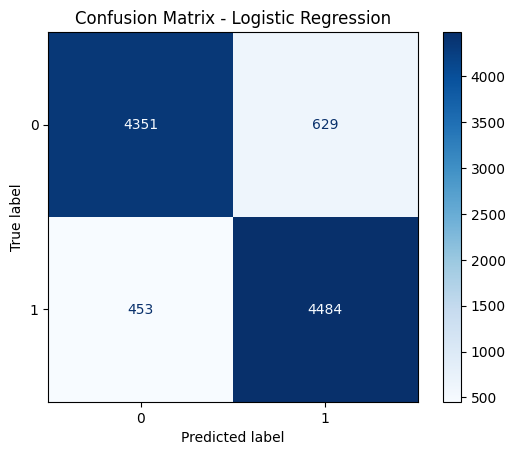

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/FINAL//LR_confusion_matrix_test.png


In [ ]:
# Print and Save Classification Report
lr_report = classification_report(y_test, y_test_pred, output_dict=True)
lr_report_file = f"{target_folder}/logistic_regression_test_report.json"
with open(lr_report_file, 'w') as f:
    json.dump(lr_report, f)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Logistic Regression Test Report saved to: {lr_report_file}")

# Compute and Save Confusion Matrix
lr_conf_matrix = confusion_matrix(y_test, y_test_pred)
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix, display_labels=lr_model.classes_)
lr_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
lr_cm_file = f"{target_folder}/LR_confusion_matrix_test.png"
plt.savefig(lr_cm_file)
plt.show()
print(f"Confusion matrix saved to: {lr_cm_file}")

#Model Training and Evaluation - Support Vector Machine

- Train model using SVM

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Load tfidf train and test dataset
X_train_tfidf_SVM = joblib.load(f"{target_folder}/X_train_tfidf.pkl")
X_test_tfidf_SVM = joblib.load (f"{target_folder}/X_test_tfidf.pkl")

# Load the labels
train_data = pd.read_csv(f"{target_folder}/train_stopword.csv")
test_data = pd.read_csv(f"{target_folder}/test_stopword.csv")
y_train_SVM = train_data["label"]
y_test_SVM = test_data["label"]

In [ ]:
# Step 1: Scale the data (SVM requires scaling sa model is sensitive to feature magnitudes)
scaler = StandardScaler(with_mean=False) #set mean=False as tf-idf is represented by sparse matrix
X_train_scaled_SVM = scaler.fit_transform(X_train_tfidf_SVM)
X_test_scaled_SVM = scaler.transform(X_test_tfidf_SVM)

In [ ]:
# Step 2: Train SVM with default parameters
svm_model = SVC()  # Default kernel='rbf', C=1.0, gamma='scale'
svm_model.fit(X_train_scaled_SVM, y_train_SVM)

# Save the trained SVM model and scaler
joblib.dump(svm_model, f"{target_folder}/svm_model.pkl")
joblib.dump(scaler, f"{target_folder}/svm_scaler.pkl")
print("SVM model and scaler saved.")

SVM model and scaler saved.


- Test on SVM model

In [ ]:
# Load the saved SVM model
svm_model = joblib.load(f"{target_folder}/svm_model.pkl")

# Make predictions on the scaled test data
y_test_pred_SVM = svm_model.predict(X_test_scaled_SVM)


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4980
           1       0.81      0.89      0.85      4937

    accuracy                           0.84      9917
   macro avg       0.85      0.84      0.84      9917
weighted avg       0.85      0.84      0.84      9917

SVM Test Report saved to: /content/drive/MyDrive/SPNLP/FINAL//svm_test_report.json


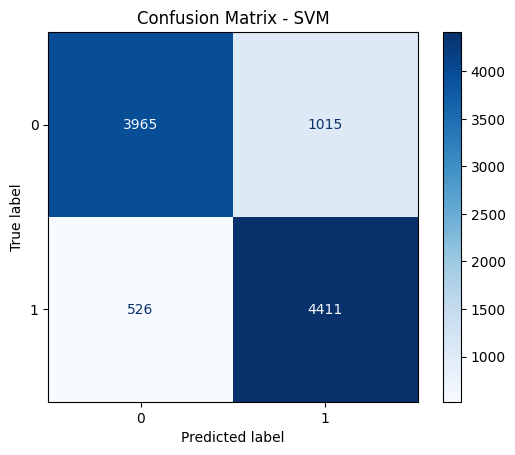

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/FINAL//SVM_confusion_matrix_test.png


In [ ]:
# Print and Save Classification Report
svm_report = classification_report(y_test_SVM, y_test_pred_SVM, output_dict=True)
svm_report_file = f"{target_folder}/svm_test_report.json"
with open(svm_report_file, 'w') as f:
    json.dump(svm_report, f)
print("\nSVM Classification Report:")
print(classification_report(y_test_SVM, y_test_pred_SVM))
print(f"SVM Test Report saved to: {svm_report_file}")

# Compute and Save Confusion Matrix
svm_conf_matrix = confusion_matrix(y_test_SVM, y_test_pred_SVM)
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_conf_matrix, display_labels=svm_model.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
svm_cm_file = f"{target_folder}/SVM_confusion_matrix_test.png"
plt.savefig(svm_cm_file)
plt.show()
print(f"Confusion matrix saved to: {svm_cm_file}")

#Model Training and Evaluation - DistilBERT

  - Perform DistilBERT fine tuning on raw data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

target_folder = '/content/drive/MyDrive/SPNLP/FINAL/'

Mounted at /content/drive


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import pandas as pd

In [ ]:
# Load dataset
train_data = pd.read_csv(f"{target_folder}/train_raw_data.csv")

In [ ]:
# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

# Prepare text and labels
texts = train_data['text'].tolist()  # Preprocessed text
labels = train_data['label'].tolist()  # Sentiment labels (0 or 1)

# Create dataset and dataloader
train_dataset = IMDBDataset(texts, labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load DistilBERT tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Fine-tuning parameters
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

# Determine device (GPU, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use CUDA (NVIDIA GPU)
    print("Using GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Use Metal Performance Shaders (Apple Silicon GPU)
    print("Using GPU (MPS)")
else:
    device = torch.device('cpu')  # Fallback to CPU
    print("Using CPU")

# Move model to the determined device
model.to(device)

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        # Tokenize the text batch
        inputs = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt', max_length=512)
        labels = torch.tensor(batch['label']).to(device)

        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Forward pass
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

# Save the fine-tuned model
model.save_pretrained(f"{target_folder}/distilbert_finetuned")
tokenizer.save_pretrained(f"{target_folder}/distilbert_finetuned")
print("Model and tokenizer saved!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using GPU (CUDA)


<ipython-input-4-685d922e8d90>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.24192110750215848
Epoch 2/3, Loss: 0.1319642424213535
Epoch 3/3, Loss: 0.07315005013617572
Model and tokenizer saved!


- Evaluation on raw data using fine tuned DistilBert model
   

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load test dataset
test_data = pd.read_csv(f"{target_folder}/test_raw_data.csv")
test_texts = test_data['text'].tolist()
test_labels = test_data['label'].tolist()

In [ ]:
# Load the fine-tuned model and tokenizer
model_path = f"{target_folder}/distilbert_finetuned"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

In [ ]:
# Dataset class (reuse from training step)
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

In [ ]:
# Create test dataset and dataloader
test_dataset = IMDBDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Load the fine-tuned model and tokenizer
model_path = f"{target_folder}/distilbert_finetuned"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

In [ ]:
# Determine device (GPU, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use CUDA (NVIDIA GPU)
    print("Using GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Use Metal Performance Shaders (Apple Silicon GPU)
    print("Using GPU (MPS)")
else:
    device = torch.device('cpu')  # Fallback to CPU
    print("Using CPU")

# Move model to the determined device
model.to(device)

Using GPU (CUDA)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        # Tokenize the text batch
        inputs = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt', max_length=512)
        labels = batch['label'].to(device)

        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4980
           1       0.92      0.94      0.93      4937

    accuracy                           0.93      9917
   macro avg       0.93      0.93      0.93      9917
weighted avg       0.93      0.93      0.93      9917

Accuracy: 92.96%


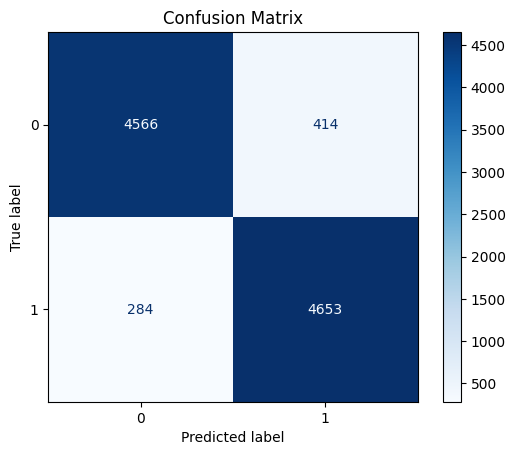

In [ ]:
# Evaluation Metrics
print("Classification Report:")
print(classification_report(true_labels, predictions))

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()